<a href="https://colab.research.google.com/github/1chooo/ML-Rainy-Predict/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **梅雨還是沒雨？**

安裝套件

Import 套件

In [1]:
# -*- coding: utf-8 -*-

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import glob

利用已取得的資料，讀取並存入讀取並存入data frame

In [2]:
data_path = 'merged_data.csv'

In [3]:
df = pd.read_csv(data_path)

Explore the data we have.

In [4]:
df.info()
df.head()
df.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 854 entries, 0 to 853
Data columns (total 35 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ObsTime         854 non-null    int64  
 1   StnPres         854 non-null    object 
 2   SeaPres         854 non-null    object 
 3   StnPresMax      854 non-null    object 
 4   StnPresMaxTime  854 non-null    object 
 5   StnPresMin      854 non-null    object 
 6   StnPresMinTime  854 non-null    object 
 7   Temperature     854 non-null    object 
 8   T Max           854 non-null    object 
 9   T Max Time      854 non-null    object 
 10  T Min           854 non-null    object 
 11  T Min Time      854 non-null    object 
 12  Td dew point    854 non-null    object 
 13  RH              854 non-null    object 
 14  RHMin           854 non-null    object 
 15  RHMinTime       854 non-null    object 
 16  WS              854 non-null    object 
 17  WD              854 non-null    obj

,count,mean,std,min,25%,50%,75%,max
ObsTime,854.0,15.754098,8.812117,1.0,8.0,16.0,23.0,31.0
Precp,854.0,8.038642,21.628585,0.0,0.0,0.0,4.0,312.0


由上看出有些資料我們並不需要，因此我們加以整理，因此移除我們覺得不需要的變數

再觀察一下我們的資料

首先我們看到幾乎所有資料的型態都為object並且都沒有缺失值，因此我們要對此處理，結果發現轉換不了，有些原始資料的缺失值會以「...」的方式補齊，所以我們要先把「...」先替代掉，再把data type轉換成轉換成float。

In [5]:
df.drop(['ObsTime', 'SeaPres', 'StnPresMaxTime', 'StnPresMinTime'], axis = 1, inplace = True)
df.drop(['T Max Time', 'T Min Time', 'Td dew point'], axis = 1, inplace = True)
df.drop(['RHMinTime', 'WGustTime'], axis = 1, inplace = True)
df.drop(['PrecpHour', 'PrecpMax10', 'PrecpMax10Time', 'PrecpMax60', 'PrecpMax60Time'], axis = 1, inplace = True)
df.drop(['SunShine', 'SunShineRate', 'GloblRad', 'VisbMean'], axis = 1, inplace = True)
df.drop(['EvapA', 'UVI Max', 'UVI Max Time', 'Cloud Amount'], axis = 1, inplace = True) 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 854 entries, 0 to 853
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   StnPres      854 non-null    object 
 1   StnPresMax   854 non-null    object 
 2   StnPresMin   854 non-null    object 
 3   Temperature  854 non-null    object 
 4   T Max        854 non-null    object 
 5   T Min        854 non-null    object 
 6   RH           854 non-null    object 
 7   RHMin        854 non-null    object 
 8   WS           854 non-null    object 
 9   WD           854 non-null    object 
 10  WSGust       854 non-null    object 
 11  WDGust       854 non-null    object 
 12  Precp        854 non-null    float64
dtypes: float64(1), object(12)
memory usage: 86.9+ KB


In [6]:
df = df.replace('...','-999')
df = df.replace('/','-999')


for i in range(854):
    for j in range(0, 13):
        if df.iloc[i, j] == '-999':
            df.iloc[i, j] = 0.0

# df = pd.DataFrame(df, dtype = np.float)

In [7]:
df = pd.DataFrame(df, dtype = np.float64)

再觀察一下我們的資料

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 854 entries, 0 to 853
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   StnPres      854 non-null    float64
 1   StnPresMax   854 non-null    float64
 2   StnPresMin   854 non-null    float64
 3   Temperature  854 non-null    float64
 4   T Max        854 non-null    float64
 5   T Min        854 non-null    float64
 6   RH           854 non-null    float64
 7   RHMin        854 non-null    float64
 8   WS           854 non-null    float64
 9   WD           854 non-null    float64
 10  WSGust       854 non-null    float64
 11  WDGust       854 non-null    float64
 12  Precp        854 non-null    float64
dtypes: float64(13)
memory usage: 86.9 KB


我們先處理降雨量，因為有降水及代表有下雨，所以只要大於大於0就轉換為1，反之轉換為0。

In [9]:
for k in range(854):
    if df.iloc[k,12] > 0.0:
        df.iloc[k,12] = 1
    else:
        df.iloc[k,12] = 0

有些資料我們打算用平均值來填補，並取到小數點後第一位

In [10]:
count0, count1, count2, count3, count4, count5, count8 , count10 = 0, 0, 0, 0 ,0, 0, 0, 0
stnprestotal , stnpresmaxtotal , stnpresmintotal, WStotal , WSGusttotal, Ttotal , Tmaxtotal , Tmintotal = 0 , 0 , 0, 0 , 0, 0 , 0 , 0

for k in range(0,853):
    if (df.iloc[k,0] != -999.0):
        stnpres = float(df.iloc[k,0])
        count0 += 1
        stnprestotal += stnpres
    if (df.iloc[k,1] != -999.0):
        stnpresmax = float(df.iloc[k,1])
        count1 += 1
        stnpresmaxtotal += stnpresmax
    if (df.iloc[k,2] != -999.0):
        stnpresmin = float(df.iloc[k,2])
        count2 += 1
        stnpresmintotal += stnpresmin
    if (df.iloc[k,3] != -999.0):
        T = float(df.iloc[k,3])
        count3 += 1
        Ttotal += T
    if (df.iloc[k,4] != -999.0):
        Tmax = float(df.iloc[k,4])
        count4 += 1
        Tmaxtotal += Tmax
    if (df.iloc[k,5] != -999.0):
        Tmin = float(df.iloc[k,5])
        count5 += 1
        Tmintotal += Tmin
    if (df.iloc[k,8] != -999.0):
        WS = float(df.iloc[k,8])
        count8 += 1
        WStotal += WS
    if (df.iloc[k,10] != -999.0):
        WSGust = float(df.iloc[k,10])
        count10 += 1
        WSGusttotal += WSGust

ave0 = round(stnprestotal / count0 , 1)
ave1 = round(stnpresmaxtotal / count1 , 1)
ave2 = round(stnpresmintotal / count2 , 1)
ave3 = round(Ttotal / count3 , 1)
ave4 = round(Tmaxtotal / count4 , 1)
ave5 = round(Tmintotal / count5 , 1)
ave8 = round(WStotal / count8 , 1)
ave10 = round(WSGusttotal / count10 , 1)

for c in range(854):
    if df.iloc[c,0] == -999.0:
        df.iloc[c,0] = ave0
    if df.iloc[c,1] == -999.0:
        df.iloc[c,1] = ave1
    if df.iloc[c,2] == -999.0:
        df.iloc[c,2] = ave2
    if df.iloc[c,3] == -999.0:
        df.iloc[c,3] = ave3
    if df.iloc[c,4] == -999.0:
        df.iloc[c,4] = ave4
    if df.iloc[c,5] == -999.0:
        df.iloc[c,5] = ave5
    if df.iloc[c,8] == -999.0:
        df.iloc[c,8] = ave8
    if df.iloc[c,10] == -999.0:
        df.iloc[c,10] = ave10

剩下的資料我們以眾數的方式來填補缺失值

In [11]:
for i in range(854):
    if df.iloc[i,6] == -999.0:
            df.iloc[i,6] = df['RH'].value_counts().idxmax()

for i in range(854):
    if df.iloc[i,7] == -999.0:
            df.iloc[i,7] = df['RHMin'].value_counts().idxmax()           

for i in range(854):
    if df.iloc[i,9] == -999.0:
            df.iloc[i,9] = df['WD'].value_counts().idxmax()

for i in range(854):
    if df.iloc[i,11] == -999.0:
            df.iloc[i,11] = df['WDGust'].value_counts().idxmax()

接著我們看看，每個各別資料對雨量的關係圖

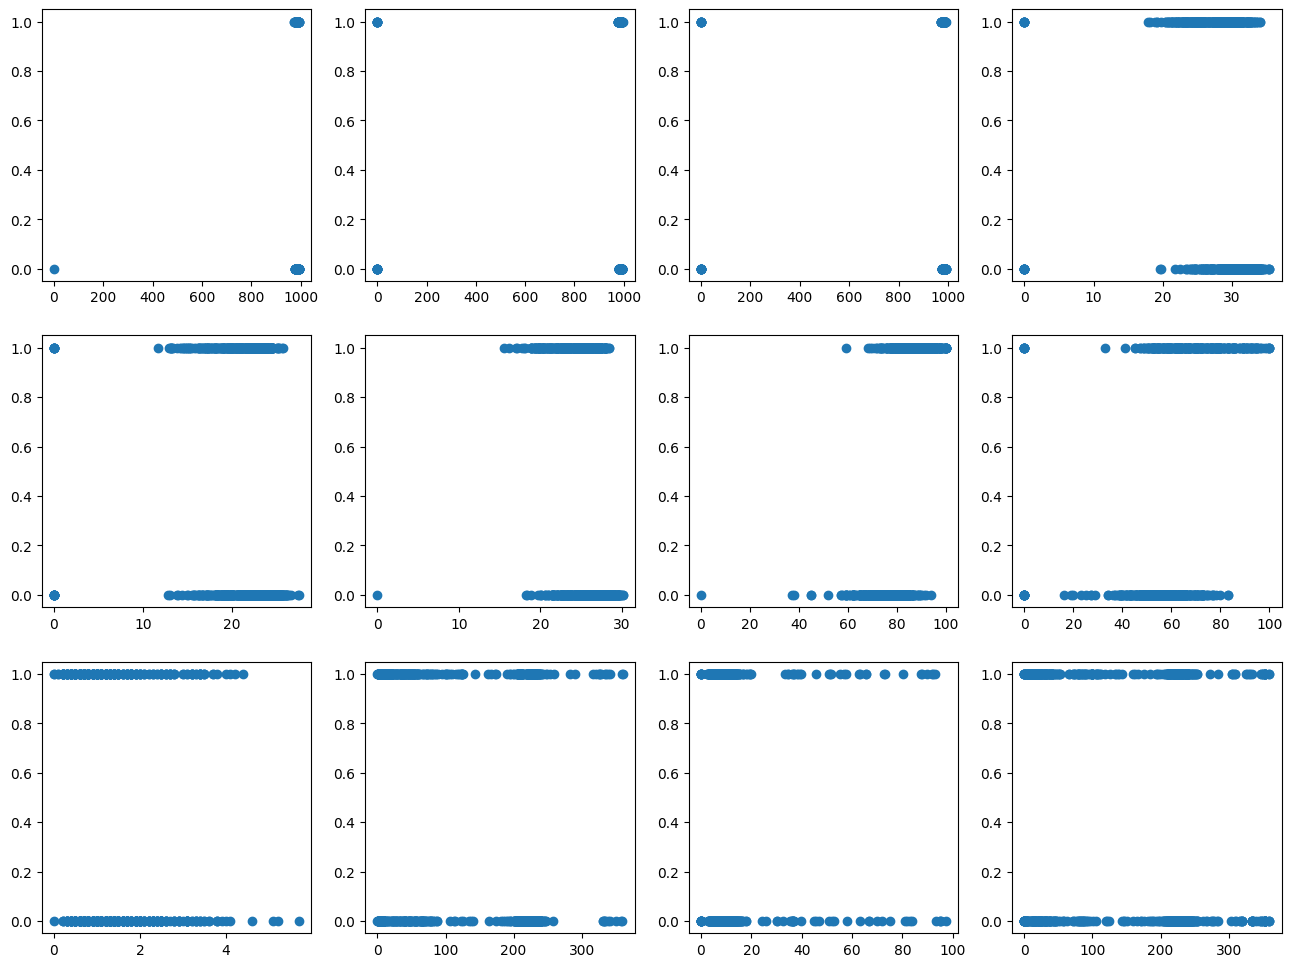

In [12]:
x1 = df['StnPres']
x2 = df['StnPresMax']
x3 = df['StnPresMin']
x4 = df['T Max']
x5 = df['T Min']
x6 = df['Temperature']
x7 = df['RH']
x8 = df['RHMin']
x9 = df['WS']
x10 = df['WD']
x11 = df['WSGust']
x12 = df['WDGust']
y = df['Precp']

plt.figure(figsize=(16, 12))

plt.subplot(3, 4, 1)
plt.scatter(x1,y)
plt.subplot(3, 4, 2)
plt.scatter(x2,y)
plt.subplot(3, 4, 3)
plt.scatter(x3,y)
plt.subplot(3, 4, 4)
plt.scatter(x4,y)
plt.subplot(3, 4, 5)
plt.scatter(x5,y)
plt.subplot(3, 4, 6)
plt.scatter(x6,y)
plt.subplot(3, 4, 7)
plt.scatter(x7,y)
plt.subplot(3, 4, 8)
plt.scatter(x8,y)
plt.subplot(3, 4, 9)
plt.scatter(x9,y)
plt.subplot(3, 4, 10)
plt.scatter(x10,y)
plt.subplot(3, 4, 11)
plt.scatter(x11,y)
plt.subplot(3, 4, 12)
plt.scatter(x12,y)

plt.show()

接著我們看看，每個各別變數之間相關係數

In [13]:
df.corr()

,StnPres,StnPresMax,StnPresMin,Temperature,T Max,T Min,RH,RHMin,WS,WD,WSGust,WDGust,Precp
StnPres,1.000000,0.240201,0.240289,0.272549,0.168845,0.153820,0.285313,0.132303,0.044859,0.033314,0.015842,0.035912,0.019570
StnPresMax,0.240201,1.000000,0.999973,0.056268,0.768712,0.729879,0.074762,0.553902,0.043982,0.034027,0.111267,0.215487,-0.001650
StnPresMin,0.240289,0.999973,1.000000,0.056728,0.768907,0.730449,0.074363,0.553597,0.042953,0.033559,0.110630,0.215243,-0.002730
Temperature,0.272549,0.056268,0.056728,1.000000,0.615459,0.563524,-0.304349,-0.331209,-0.110673,0.564645,0.089133,0.405178,-0.406448
T Max,0.168845,0.768712,0.768907,0.615459,1.000000,0.865799,-0.259750,0.089095,-0.046342,0.365773,0.152831,0.409718,-0.295950
T Min,0.153820,0.729879,0.730449,0.563524,0.865799,1.000000,-0.043790,0.317525,-0.035807,0.298919,0.146913,0.379962,-0.151575
RH,0.285313,0.074762,0.074363,-0.304349,-0.259750,-0.043790,1.000000,0.745634,-0.311686,-0.260921,-0.126060,-0.187863,0.616572
RHMin,0.132303,0.553902,0.553597,-0.331209,0.089095,0.317525,0.745634,1.000000,-0.133481,-0.233848,-0.090241,-0.066406,0.445047
WS,0.044859,0.043982,0.042953,-0.110673,-0.046342,-0.035807,-0.311686,-0.133481,1.000000,-0.050616,0.049441,-0.077140,-0.093244
WD,0.033314,0.034027,0.033559,0.564645,0.365773,0.298919,-0.260921,-0.233848,-0.050616,1.000000,0.086360,0.423635,-0.252854


我們接著再把所有資料都餵給模型，來觀察模型辨識程度

In [14]:
X = df.drop(['Precp'], axis=1)
y = df['Precp']

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

X_train,X_test, y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=67)
lr = LogisticRegression(max_iter=200)
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)
accuracy_score(y_test, predictions)
recall_score(y_test, predictions)
precision_score(y_test, predictions)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7647058823529411

經過多次交叉測試後，發現什麼都沒有刪除，分數會最高

In [15]:
X = df.drop(['Precp'], axis=1)
y = df['Precp']
X_train,X_test, y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=67)
lr = LogisticRegression(max_iter=200)
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)
accuracy_score(y_test, predictions)
recall_score(y_test, predictions)
precision_score(y_test, predictions)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7647058823529411

接著我們圖表化看出模型的矩陣關係


In [16]:
pd.DataFrame(confusion_matrix(y_test, predictions), columns = ['Predict not rain','Predict rain'], index=['True not rain', 'True rain'])

,Predict not rain,Predict rain
True not rain,148,20
True rain,24,65


最後我們測試模型的辨認是否順利，然後有發現到測出來的型態為[1.]、[0.]

In [17]:
print(lr.predict([[900, 1000, 850, 23, 27, 18, 34, 12, 1, 23, 2, 45]]))
print(lr.predict([[900, 860, 950 , 26, 31, 20, 70 , 50 , 3 , 20 , 6 , 25 ]]))

[1.]
[0.]


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


利用joblib模組將模型匯出

In [18]:
import joblib
joblib.dump(lr,'Precipitation_Predict.pkl',compress=3)

['Precipitation_Predict.pkl']